# Learning the topology of a Bayesian Network from a database of cases using the K2 algorithm

A **Bayesian belief-network** [1] structure is a directed acyclic graph in which nodes represent domain variables and arcs between nodes represent probabilistic dependencies [2]. Given a database of records, it is interesting to construct a probabilistic network that can provide insights into the probabilistic dependencies existing among the variables in the database. Such a network can be further used to classify future behavior of the modeled system [2]. 

Although researchers have made substantial advances in developing the theory and application of belief networks, the actual construction of these networks often remains a difficult, time-consuming task. An efficient method for determining the relative probabilities of different belief-network structures, given a database of cases and a set of explicit assumptions, is described in [2] and [3].

The K2 algorithm [3] can be used to learn the topology of a Bayes network [2], i.e. of finding the most probable belief-network structure, given a database.
- **Part 1** After having studied the problem in the suggested literature ([2]-[3]), Implement the algorithm in R and check its performances with the test data set given in [3]: Asia and Child data sets.
- **Part 2** Implement and test the K2 algorithm with the test data sets ([3]). Compare the results with that obtained with the bnstruct R library [4]

## Bibliography
[1]: **Bayesian Networks**: (Link to relevant paper or article) <br>
[2]: **A Bayesian Method for the Induction of Probabilistic Networks from Data**: ([Link](https://link.springer.com/article/10.1007/BF00994110#Bib1)) <br>
[3]: **Illustration of the K2 Algorithm for learning Bayes Net Structures**: ([Link](https://web.cs.wpi.edu/~cs539/s05/Projects/k2_algorithm.pdf)) <br>
[4]: **bnstruct: an R package for Bayesian Network structure learning in the presence of missing data**: ([Link](https://academic.oup.com/bioinformatics/article/33/8/1250/2730229)) <br>
[5]: **bnstruct: an R package for Bayesian Network Structure Learning with missing data**: ([Link](https://cran.r-project.org/web/packages/bnstruct/vignettes/bnstruct.pdf)) <br>

In [ ]:
# da scaricare per plottare le reti
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")

#BiocManager::install("Rgraphviz")

In [73]:
library("bnstruct") %>% suppressPackageStartupMessages()
#library("bnlearn")
library("qgraph") %>% suppressPackageStartupMessages()
#library("Rgraphviz")
library("tidyverse") %>% suppressPackageStartupMessages()

## Theory behind

In a Bayesian Network, each variable is associated to a **node**. The number
of variables is the **size** of the network. Each variable has a certain range of values it can take: any possible value $\rightarrow$ *continuous* variable; otherwise, if a variable can only take some values in its range, it is a discrete variable.
- *raw dataset*: original dataset where some observations are absent
- *imputed dataset*: the dataset with the "holes filled"


- **missing data** $\rightarrow$ **imputation**: 
1. inference task: we want to guess a reasonable value that would have been present in the dataset if the observations were successful
2. uses the k-Nearest Neighbour algorithm: `k.impute` to choose the number of neighbours
```R
dataset <- impute(dataset, k.impute = 10)
imputed.data(dataset)
```
- **bootstrap**:
1. Bootstrap samples are created by randomly sampling with replacement from original data, creating new datasets of the same size as the original.
2. with `imputation` enabled - in case of dataset with missing values:
   - **first samples** rows with replacement from the raw dataset, including those missing values
   - **then perform imputation** on each bootstrap raw sample filling in the missing values
```R
dataset <- bootstrap(dataset, num.boots = 100, imputation = TRUE)

```

When constructing a network starting from a dataset, the first operation we may want to perform is **to learn a network that may have generated that dataset**, in particular its structure and its parameters. `bnstruct` provides the `learn.network` method for this task. <br>
There are **five algorithms** to learn the structure of the network that can be chosen with the `algo` parameter:
- `sm` (constraint-based): Silander-Myllymäki exact *search-and-score* algorithm (takes very long time, inapplicable for more than 25-30 nodes). Even for small networks, strongly encouraged to provide meaningful parameters such as the layering of the nodes, or the maximum number of parents;
- `mmpc` (constraint-based): Max-Min Parent-and-Children - discovers the *skeletron* of the network (the set of edges connecting the variables without their directionality)
- `hc` (score-based): Hill Climbing method - **the most similar to our K2**
- `mmhc` (hybrid) *deafult*: Max-Min Hill-Climbing - combination of the previous two algorithms. A confidence threshold `alpha` can be specified
- `sem` (score-based): Structural Expectation-Maximization for dataset with **missing values**. Convergence can be controlled with `struct.threshold`, `param.threshold`, `max.sem.iterations`

These methods also need a **scoring function** to compute an estimated measure of each configuration of nodes, choosen with `scoring.func` parameter:
- `BDeu` *default*: Bayesian-Dirichlet equivalent uniform
- `AIC`: Akaike Information Criterion
- `BIC`: Bayesian Information Criterion

It's possible to provide an initial network as starting point for the search with `initial.network`.

"The overall best results are obtained using `MMHC` with `BDeu` after dataset imputation. `MMHC` converges in few seconds even for the large Hepar2 network; conversely, `SEM` takes from few minutes up to few hours, often with worse results. `SEM` paired with `BIC` failed to converge in 24 hours for all the 20 datasets." <br>

- `MMHC` + `BDeu` $\rightarrow$ TOP
- `SEM` + `BDeu` $\rightarrow$ meh
- `SEM` + `BIC` $\rightarrow$ NO!!

$\Rightarrow$ `SEM` fa schifo
<br>
In terms of solution quality, the results clearly improve as the size of the
dataset grows. For 10000 observations BDeu finds slightly better networks, in
terms of similarity with the original one, than BIC, while for **smaller datasets BIC** is significantly more robust

### Test easy sul dataset dell'articolo

In [ ]:
data <- matrix(data = c(1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 
                        0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
                       0, 1, 1, 1, 0, 1, 1, 0, 1, 0), ncol = 3)

# to create a BNDataset
easy_dataset <- BNDataset(data = data,
                          discreteness = rep("d", 3),
                          variables = c("x1", "x2", "x3"),
                          node.sizes = c(2,2,2),
                          starts.from=0,  # otherwise it starts from 1 to |x| that here is also 1
                          bndataset.name = "Test dataset")

easy_dataset  # print() or show() is the same

In [ ]:
# to get the data of a BNDataset
raw.data(easy_dataset)

In [ ]:
easy_net <- learn.network(easy_dataset)

In [ ]:
# DAG: Directed Acyclic Graph
# WPDAG: Weighted Partially DAG when bootstrap is performed
dag(easy_net)

plot(easy_net, method="qgraph", 
     label.scale.equal = T,
     node.width = 1.6)

In [ ]:
# to learn a WPDAG starting from a network with a DAG
#wpdag.from.dag(easy_net)

In [ ]:
# bootstrap: num.boots random samples of the same size of dataset
# ex: here 300 samples of size data with replicated values
easy_boot_dataset <- bootstrap(object = easy_dataset, 
                               num.boots = 3)

easy_boot_net <- learn.network(easy_boot_dataset, bootstrap = TRUE)

In [ ]:
wpdag(easy_boot_net)

In [ ]:
show(easy_boot_net)

In [ ]:
plot(easy_boot_net, method="qgraph", 
     label.scale.equal = T,
     node.width = 1.6,
     plot.wpdag = TRUE)

# Part 2: bnlearn library
Implement and test the K2 algorithm with the test data sets ([3]). Compare the results with that obtained with the bnstruct R library [4]

IDEA: plottare SHD (Structural Hamming Distance) vs time(s)
<br> SHD = the distance in terms of edges from the original network

## Child dataset

- BNDataset containing the Child dataset
- It has 5000 items
- random **missing values**
- no latent variables
- raw dataset and imputed dataset (with k = 10)

In [33]:
child_dataset <- child()
class(child_dataset)
child_dataset

[1] "BNDataset"
attr(,"package")
[1] "bnstruct"


Dataset: 

num.variables 20

variables
BirthAsphyxia Disease Age LVH DuctFlow CardiacMixing LungParench LungFlow Sick HypDistrib HypoxiaInO2 CO2 ChestXray Grunting LVHReport LowerBodyO2 RUQO2 CO2Report XrayReport GruntingReport
discreteness
TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
node.sizes
2 6 3 2 3 4 3 3 2 2 3 3 5 2 2 3 3 2 5 2
num.items
5000
imputation
FALSE
has.boots
FALSE
has.imputed.boots
FALSE
num.boots
0

In [35]:
head(raw.data(child_dataset), 10)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
2,3,3,NA,1,NA,1,1,2,1,1,1,NA,2,2,2,3,2,1,2
NA,NA,2,1,1,2,1,2,2,1,2,1,2,2,NA,2,2,1,2,2
2,3,1,2,1,NA,NA,2,2,1,2,2,2,2,2,1,2,1,2,2
2,4,1,1,1,3,NA,1,2,NA,3,NA,1,2,1,3,1,NA,1,NA
2,2,1,NA,2,4,1,1,1,1,NA,1,NA,2,NA,NA,1,1,2,2
NA,2,NA,2,1,4,NA,3,2,1,3,1,3,2,2,2,1,1,3,2
2,2,1,2,NA,4,NA,3,NA,1,NA,1,1,NA,NA,NA,1,1,1,NA
NA,1,1,NA,3,1,1,1,2,2,2,1,4,2,2,1,1,NA,4,NA
2,3,2,2,1,3,1,2,2,1,2,1,2,2,2,NA,1,1,2,2
2,4,1,1,1,3,NA,NA,2,NA,3,3,2,2,1,1,1,2,2,NA


In [22]:
#complete(child_dataset)        why doesn't workkkkkkkkkkkkkkkkk

In [21]:
#child_dataset <- impute(dataset)   # OCCHIO: non va se carico bnlearn - ci sono due funzioni omonime e una non va con BNDatabase
#imputed.data(child_dataset)

In [37]:
child_net <- learn.network(child_dataset)

bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.



In [46]:
# useful functions to inspect the net
#dag(child_net)
#cpts(child_net)
#show(child_net)   # or print()

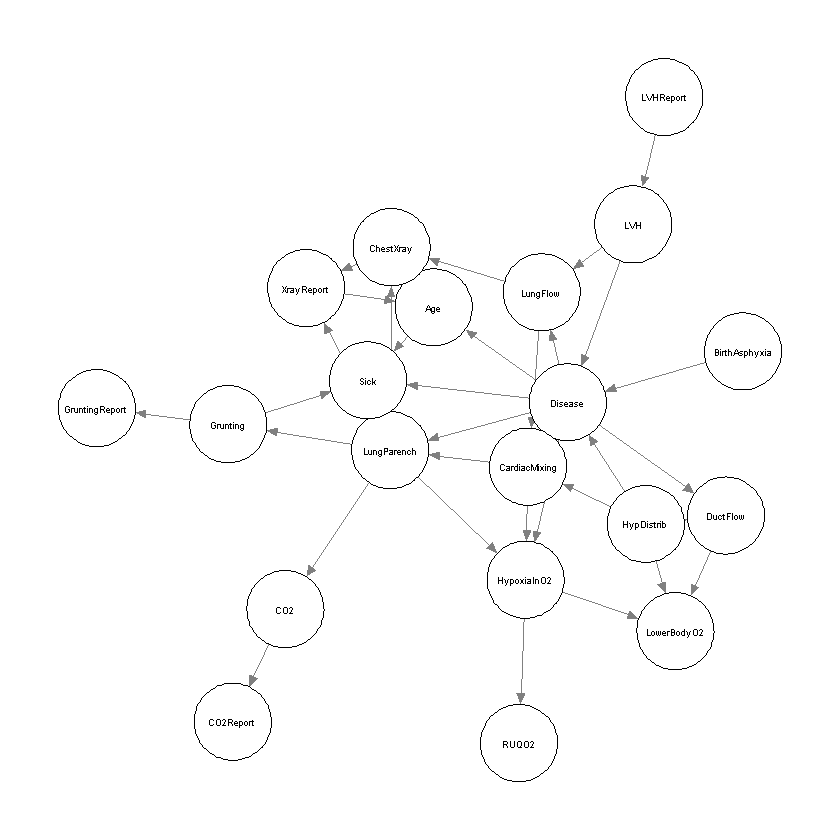

In [42]:
plot(child_net, method = "qgraph",
    label.scale.equal = TRUE,
    node.width = 1.2)

In [47]:
# now learning with imputed data
child_dataset <- child()
child_imputed <- impute(child_dataset)

bnstruct :: performing imputation ...

bnstruct :: imputation finished.



In [49]:
child_imputed_net <- learn.network(child_imputed, use.imputed.data = TRUE)

bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.



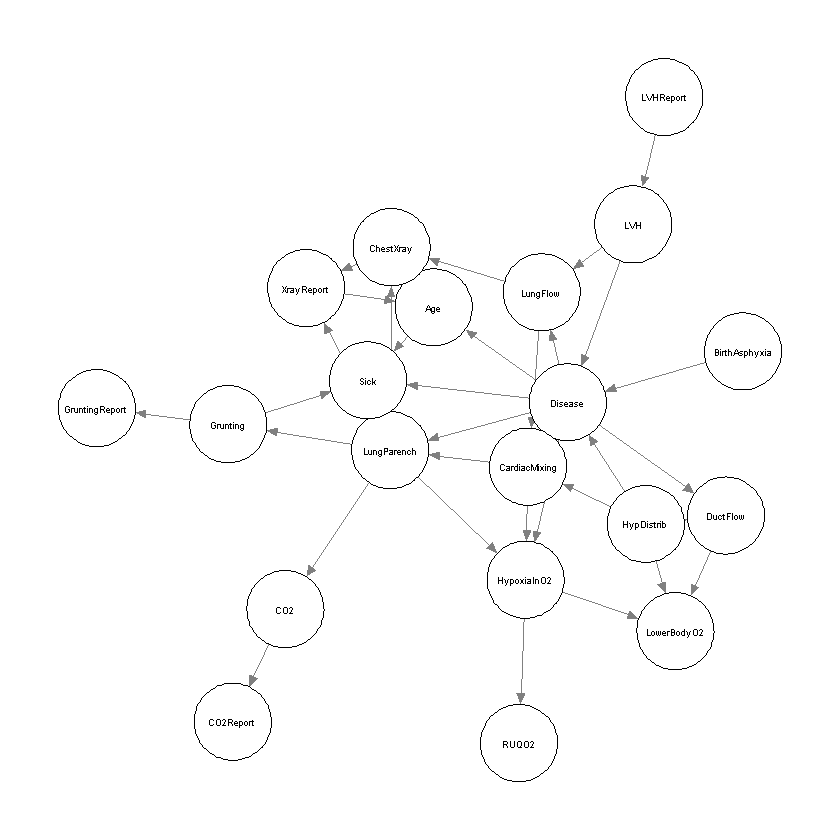

In [50]:
plot(child_net, method = "qgraph",
    label.scale.equal = TRUE,
    node.width = 1.2)

## Asia Dataset

- BNDataset containing the Child dataset
- It has 10000 items
- no missing data (so no imputation needed)

In [63]:
asia_dataset <- asia()
class(asia_dataset)
asia_dataset

[1] "BNDataset"
attr(,"package")
[1] "bnstruct"


Dataset: 

num.variables 8

variables
Asia Tubercolosys Smoke LungCancer Bronchitis Either X-ray Dyspnea
discreteness
TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
node.sizes
2 2 2 2 2 2 2 2
num.items
10000
imputation
FALSE
has.boots
FALSE
has.imputed.boots
FALSE
num.boots
0

In [54]:
head(raw.data(asia_dataset), 5)

V1,V2,V3,V4,V5,V6,V7,V8
2,2,1,1,1,2,1,2
2,1,1,1,1,1,2,1
1,1,2,1,1,1,2,1
2,1,2,1,1,1,2,1
2,1,2,1,1,1,1,2


In [64]:
asia_dataset <- bootstrap(asia_dataset)   # default value is num.boots = 100

bnstruct :: Generating bootstrap samples ...

bnstruct :: Bootstrap samples generated.



In [69]:
asia_net <- learn.network(asia_dataset, bootstrap = TRUE)

bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.



In [80]:
class(asia_net)

[1] "BN"
attr(,"package")
[1] "bnstruct"

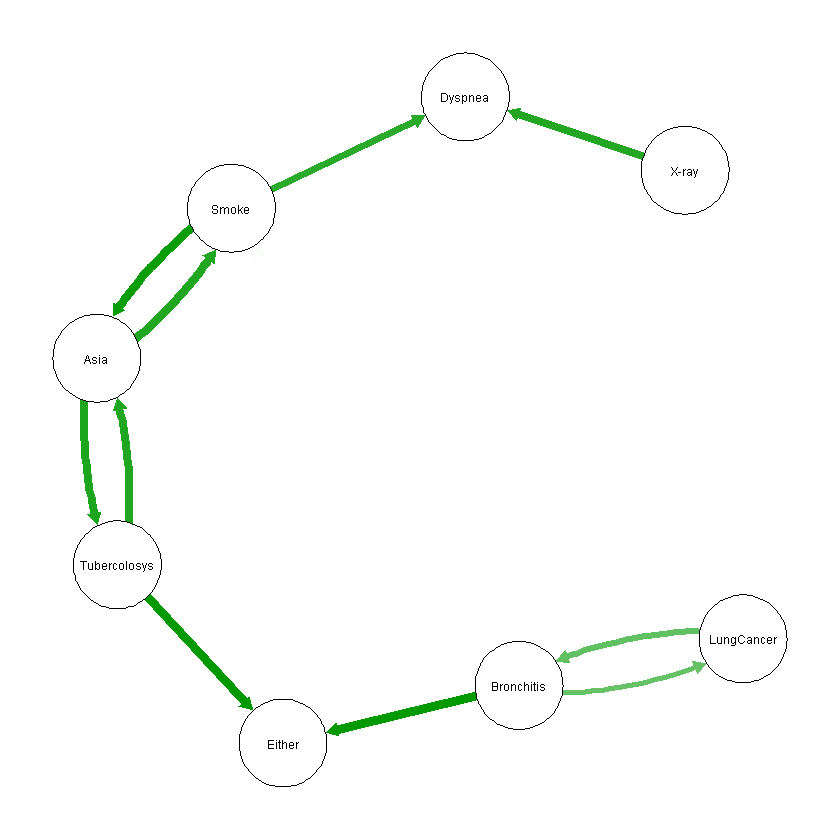

In [74]:
plot(asia_net, method = "qgraph",
    label.scale.equal = TRUE,
    node.width = 1.2,
    plot.wpdag = TRUE)

In [67]:
'''
function() {
    start <- Sys.time()
    #...
    end <- Sys.time()
    execution_time <- difftime(start, end, units = "secs")
}
'''

ERROR: Error in parse(text = input): <text>:1:3: costante stringa inattesa
7: }
8: '
     ^


In [ ]:
'''
time_taken <- system.time({
    
    dataset <- child()
    
    # try all the possible combinations of algorithms and scoring functions
    algos <- c("sm", "mmpc", "mmhc", "hc", "sem")
    scoring_funcs <- c("BDeu")#, "AIC", "BIC")
    
    combinations <- expand.grid(algo = algos, scoring_func = scoring_funcs, stringsAsFactors = FALSE)
    
    learn_net <- function(algo, scoring_func) {
        tryCatch({
            net <- learn.network(dataset, algo = algo, 
                                 scoring.func = scoring_func)
            return(net)
        }, error = function(e) {
            message(sprintf("Error with algorithm %s and score %s: %s", algo, scoring_func, e$message))
            return(NULL)
        })
    }
    
    nets <- mapply(learn_net, combinations$algo, combinations$scoring_func, SIMPLIFY = FALSE)
})
print(time_taken)
'''